In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import qtree 
import utils
import utils_qaoa as qaoa

%load_ext autoreload
%autoreload 2

ModuleNotFoundError("No module named 'tensorflow'")


In [2]:
def get_test_graph(S):
    G = nx.triangular_lattice_graph(S, S)
    # remove grid labelling
    gen = (x for x in range(G.number_of_nodes()))
    G = nx.relabel_nodes(G, lambda x: next(gen))
    return G

def get_test_qaoa(S):
    G = get_test_graph(S)
    N = G.number_of_nodes()
    beta, gamma = [np.pi/3], [np.pi/2]
    qc = qaoa.get_qaoa_circuit(G, beta, gamma)
    return qc, N

def get_test_expr_graph(S):
    qc, N = get_test_qaoa(S)
    graph = qtree.graph_model.circ2graph(N, qc)
    return graph, N

def get_optimized_expr(S):
    graph, N = get_test_expr_graph(S)
    peo, nghs = utils.get_locale_peo(graph, utils.n_neighbors)
    graph_opt, slice_dict = utils.reorder_graph(graph, peo)
    return graph_opt, nghs, N

def get_cost_of_task(S):
    graph_opt, nghs, N = get_optimized_expr(S)
    mems, flops = qtree.graph_model.cost_estimator(graph_opt)
    return mems,flops,nghs, N

2020-03-04 20:45:29,146- INFO•	Generated graph with 174 nodes and 399 edges


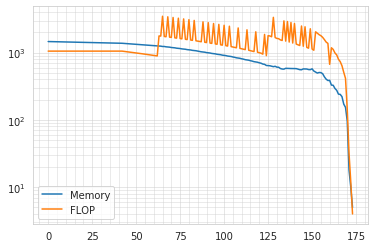

In [3]:
mems, flops, nghs, N = get_cost_of_task(5)
utils.plot_cost(mems, flops)

In [57]:
sizes = np.arange(5,18,1)

def get_est(xs, vals):
    mem_est = np.polyfit(np.log(xs), np.log(vals), 2)
    mem_est = np.poly1d(mem_est)
    est = np.linspace(20,1e3, 100)
    est = np.log(est)
    mem_est = mem_est(est)
    return np.exp(est),  np.exp(mem_est)


In [ ]:
results = [
   get_cost_of_task(s) for s in sizes
]
def plot_theory(results):
    sums = [[sum(x) for x in y[:3]] for y in results]
    memsums, flopsums, nghssums = zip(*sums)
    ns = list(zip(*results))[3]

    est, mem_est = get_est(ns, memsums)
    est, flop_est = get_est(ns, flopsums)


    plt.plot(ns, memsums, label='mem sum')
    plt.plot(ns, flopsums, label='flop sum')
    plt.plot(est, mem_est, '--', label='mem log-log fit')
    plt.plot(est, flop_est, '--', label='flop log-log fit')

    plt.xlabel('Number of qbits')
    plt.yscale('log')
    plt.xscale('log')
    plt.suptitle('QAOA one amplitude simulation cost', fontsize=14)
    plt.title('MaxCut triangular grids')
    plt.legend()
    plt.minorticks_on()
    plt.grid(which='minor', alpha=0.5, linestyle='-', axis='both')

plot_theory(results)

In [ ]:
plt.plot(sizes, ns)

## Profiling actual simulation

In [ ]:
from pyrofiler import mem_util, timed, timing
from pyrofiler.callbacks import append_to

In [39]:
profile = {}

@mem_util(description='mem', callback=append_to(profile))
@timed('time', callback=append_to(profile))
def simulate_circ(circuit, n_qubits):
    buckets, data_dict, bra_vars, ket_vars = qtree.optimizer.circ2buckets(
        n_qubits, circuit)

    graph = qtree.graph_model.buckets2graph(
        buckets,
        ignore_variables=bra_vars+ket_vars)

    peo, nghs = utils.get_locale_peo(graph, utils.n_neighbors)
    peo = qtree.graph_model.indices_to_vars(peo, graph)
    
    # place bra and ket variables to beginning, so these variables
    # will be contracted first
    #peo, treewidth = qtree.graph_model.get_peo(graph)

    peo = ket_vars + bra_vars + peo
    perm_buckets, perm_dict = qtree.optimizer.reorder_buckets(buckets, peo)

    # extract bra and ket variables from variable list and sort according
    # to qubit order
    ket_vars = sorted([perm_dict[idx] for idx in ket_vars], key=str)
    bra_vars = sorted([perm_dict[idx] for idx in bra_vars], key=str)

    # Take the subtensor corresponding to the initial state
    initial_state = target_state = 0
    slice_dict = qtree.utils.slice_from_bits(initial_state, ket_vars)
    slice_dict.update(
        qtree.utils.slice_from_bits(target_state, bra_vars)
    )
    sliced_buckets = qtree.np_framework.get_sliced_np_buckets(
        perm_buckets, data_dict, slice_dict)
    
    with timing('time_raw', callback=append_to(profile)):
        result = qtree.optimizer.bucket_elimination(
            sliced_buckets, qtree.np_framework.process_bucket_np)
        

In [80]:
for key in profile:
    profile[key] = []
    
profile['N'] = []
sizes = np.arange(5,25) 

for S in sizes[:]:
    qc, N = get_test_qaoa(S)
    profile['N'].append(N)
    print(N,'qubits')
    result = simulate_circ(qc, N)

2020-03-04 22:42:31,454- DEBUG•	Eliminating 216 buckets


21 qubits


2020-03-04 22:42:31,603- DEBUG•	Buckets eliminated
2020-03-04 22:42:31,742- DEBUG•	Eliminating 294 buckets


28 qubits


2020-03-04 22:42:31,891- DEBUG•	Buckets eliminated
2020-03-04 22:42:32,175- DEBUG•	Eliminating 384 buckets


36 qubits


2020-03-04 22:42:32,349- DEBUG•	Buckets eliminated


45 qubits


2020-03-04 22:42:32,702- DEBUG•	Eliminating 486 buckets
2020-03-04 22:42:32,996- DEBUG•	Buckets eliminated


55 qubits


2020-03-04 22:42:33,481- DEBUG•	Eliminating 600 buckets
2020-03-04 22:42:33,791- DEBUG•	Buckets eliminated


66 qubits


2020-03-04 22:42:34,453- DEBUG•	Eliminating 726 buckets
2020-03-04 22:42:34,791- DEBUG•	Buckets eliminated


78 qubits


2020-03-04 22:42:35,680- DEBUG•	Eliminating 864 buckets
2020-03-04 22:42:36,065- DEBUG•	Buckets eliminated


91 qubits


2020-03-04 22:42:36,719- DEBUG•	Eliminating 1014 buckets
2020-03-04 22:42:37,179- DEBUG•	Buckets eliminated


105 qubits


2020-03-04 22:42:37,984- DEBUG•	Eliminating 1176 buckets
2020-03-04 22:42:38,359- DEBUG•	Buckets eliminated


120 qubits


2020-03-04 22:42:39,651- DEBUG•	Eliminating 1350 buckets
2020-03-04 22:42:40,096- DEBUG•	Buckets eliminated


136 qubits


2020-03-04 22:42:41,269- DEBUG•	Eliminating 1536 buckets
2020-03-04 22:42:41,693- DEBUG•	Buckets eliminated


153 qubits


2020-03-04 22:42:43,440- DEBUG•	Eliminating 1734 buckets
2020-03-04 22:42:44,029- DEBUG•	Buckets eliminated


171 qubits


2020-03-04 22:42:45,686- DEBUG•	Eliminating 1944 buckets
2020-03-04 22:42:46,363- DEBUG•	Buckets eliminated


190 qubits


2020-03-04 22:42:48,912- DEBUG•	Eliminating 2166 buckets
2020-03-04 22:42:49,736- DEBUG•	Buckets eliminated


210 qubits


2020-03-04 22:42:52,628- DEBUG•	Eliminating 2400 buckets
2020-03-04 22:42:53,670- DEBUG•	Buckets eliminated


231 qubits


2020-03-04 22:42:56,746- DEBUG•	Eliminating 2646 buckets
2020-03-04 22:42:58,735- DEBUG•	Buckets eliminated


253 qubits


2020-03-04 22:43:02,081- DEBUG•	Eliminating 2904 buckets
2020-03-04 22:43:03,320- DEBUG•	Buckets eliminated


276 qubits


2020-03-04 22:43:07,340- DEBUG•	Eliminating 3174 buckets
2020-03-04 22:43:10,193- DEBUG•	Buckets eliminated


300 qubits


2020-03-04 22:43:15,691- DEBUG•	Eliminating 3456 buckets
2020-03-04 22:43:23,955- DEBUG•	Buckets eliminated


325 qubits


2020-03-04 22:43:30,291- DEBUG•	Eliminating 3750 buckets
2020-03-04 22:43:50,815- DEBUG•	Buckets eliminated


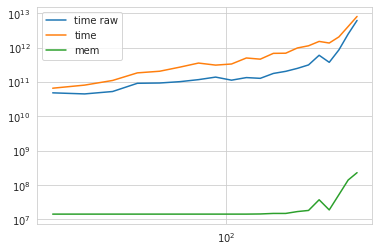

In [81]:
ns = profile['N']

def to_flop(secs):
    secs = np.array(secs)
    secs *= .3*1e12
    return secs
def to_nums(mems):
    mems = np.array(mems)
    mems = mems/16
    return mems

mems = to_nums(profile['mem'])
#mems -= np.min(mems)


plt.plot(ns, to_flop(profile['time_raw']), label='time raw')
plt.plot(ns, to_flop(profile['time']), label='time')
plt.plot(ns, mems, label='mem')
plt.legend()
plt.yscale('log')
plt.xscale('log')

In [82]:
results = [
   get_cost_of_task(s) for s in sizes
]
sums = [[sum(x) for x in y[:3]] for y in results]
memsums, flopsums, nghssums = zip(*sums)

2020-03-04 22:43:52,345- INFO•	Generated graph with 174 nodes and 399 edges
2020-03-04 22:43:53,071- INFO•	Generated graph with 238 nodes and 553 edges
2020-03-04 22:43:54,334- INFO•	Generated graph with 312 nodes and 732 edges
2020-03-04 22:43:56,119- INFO•	Generated graph with 396 nodes and 936 edges
2020-03-04 22:43:59,009- INFO•	Generated graph with 490 nodes and 1165 edges
2020-03-04 22:44:03,134- INFO•	Generated graph with 594 nodes and 1419 edges
2020-03-04 22:44:09,170- INFO•	Generated graph with 708 nodes and 1698 edges
2020-03-04 22:44:16,752- INFO•	Generated graph with 832 nodes and 2002 edges
2020-03-04 22:44:26,905- INFO•	Generated graph with 966 nodes and 2331 edges
2020-03-04 22:44:40,767- INFO•	Generated graph with 1110 nodes and 2685 edges
2020-03-04 22:44:58,746- INFO•	Generated graph with 1264 nodes and 3064 edges
2020-03-04 22:45:23,702- INFO•	Generated graph with 1428 nodes and 3468 edges
2020-03-04 22:45:54,594- INFO•	Generated graph with 1602 nodes and 3897 edges

In [ ]:
est, mem_est = get_est(ns, memsums)
est, flop_est = get_est(ns, flopsums)

fig, axs = plt.subplots(1,2, figsize=(12,5))

def log_log_scale():
    plt.yscale('log')
    plt.xscale('log')
    
def minorticks():
    plt.minorticks_on()
    plt.grid(which='minor', alpha=0.5, linestyle='-', axis='both')

plt.sca(axs[0])
log_log_scale()
minorticks()
plt.plot(ns, memsums, label='theory')
plt.plot(ns, mems, label='experiment')
plt.plot(est, mem_est, '--', label='log-log fit')
plt.legend()
plt.title('Memory')
plt.xlabel('Number of qbits')

plt.sca(axs[1])
log_log_scale()
minorticks()
plt.plot(ns, flopsums, label='theory')
plt.plot(ns, to_flop(profile['time']), label='experiment')
plt.plot(ns, to_flop(profile['time_raw']), label='experiment raw')
plt.plot(est, flop_est, '--', label='log-log fit')

plt.xlabel('Number of qbits')

plt.suptitle('QAOA one amplitude simulation cost', fontsize=14)
plt.title('FLOP')
plt.legend()


In [ ]:
filename = 'qaoa_cost_theory_exp'
plt.savefig(f'qaoa/figures/{filename}.png')
plt.savefig(f'qaoa/figures/{filename}.pdf')